# Machine Intelligence II - Team MensaNord
## Sheet 11

- Nikolai Zaki
- Alexander Moore
- Johannes Rieke
- Georg Hoelger
- Oliver Atanaszov

In [121]:
%reset -f
from __future__ import division, print_function
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.stats import multivariate_normal
import seaborn as sns

### Exercise 2


#### 1.1

In [122]:
w1, w2 = [2,2], [1,1]
sigma1, sigma2 = 0.7, 0.2
N = 100
P1, P2 = 2/3, 1/3
theta = 0.001

In [123]:
X, m  = np.zeros((N, 2)), np.zeros((N, 2))
for n in range(N):
    if np.random.rand() < P1:
        X[n] = np.random.multivariate_normal(w1, np.eye(len(w1)) * sigma1**2)
        m[n] = [1,0]
    else:
        X[n] = np.random.multivariate_normal(w2, np.eye(len(w2)) * sigma2**2)
        m[n] = [0,1]

In [125]:
#EM Algorithm:
M = 2
P_prior = np.ones(2)*1/M
P_likelihood = np.zeros((N,M))
P_posterior = np.zeros((M,N))
mu = X.mean(axis = 0)
w = np.array([mu + np.random.rand(M)-0.5, mu + np.random.rand(M)-0.5])
var = np.mean([np.linalg.norm(x - mu)**2 for x in X])
sigma = np.array([var + np.random.rand()-0.5,var + np.random.rand()-0.5])

distance = np.inf

while distance > theta:
    w_old = w.copy()
    sigma_old = sigma.copy()
    P_prior_old = P_prior.copy()
    
    for (alpha, q), _ in np.ndenumerate(P_likelihood):
        P_likelihood[alpha, q] = multivariate_normal.pdf(X[alpha], w[q], sigma[q])

    for (q, alpha), _ in np.ndenumerate(P_posterior):
        P_posterior[q, alpha] = (P_likelihood[alpha, q] * P_prior[q]) / np.sum([P_likelihood[alpha, r] * P_prior[r] for r in range(M)])
        
    distance = 0
    for q in range(M):
        w[q] = np.sum([P_posterior[q, alpha] * X[alpha] for alpha in range(N)]) / np.sum(P_posterior[q])
        distance = max(distance, np.linalg.norm(w[q] - w_old[q]))
        
        sigma[q] = 1/N * np.sum([np.linalg.norm(X[alpha] - w[q]) ** 2 * P_posterior[q, alpha] for alpha in range(N)]) / np.sum(P_posterior[q])
        distance = max(distance, np.abs(sigma[q] - sigma_old[q]))
        
        P_prior[q] = P_posterior[q].mean()
        distance = max(distance, np.abs(P_prior[q] - P_prior_old[q]))
#     print(w, sigma, P_prior)
    print(distance)
    

2.86580854657
1.70831072677
2.66724785557
1.65211466182
2.48304847507
1.99631054405
2.82723501386
1.64961675708
2.48055074021
1.99966258745
2.8305865631
1.64673269486
2.47766683044
2.00344676042
2.83437013606
1.643451849
2.4743861507
2.00777577348
2.83869840761
1.63967007504
2.47060455848
2.01280434081
2.84372603988
1.63524575481
2.46618043768
2.01875052523
2.84967101737
1.62998272823
2.46091762989
2.02593109845
2.85684999048
1.6236044238
2.45453956418
2.03482234901
2.86573905386
1.61571512472
2.44665052145
2.04616878561
2.87708239717
1.60574468118
2.43668034347
2.06118474474
2.89209382139
1.59287953994
2.42381545684
2.08193832692
2.91284053443
1.57600654891
2.40694267162
2.11207898074
2.94297060428
1.55373759745
2.38467382732
2.1580833501
2.98895901667
1.52452979612
2.35546602744
2.23042723915
3.06128061864
1.48663112702
2.31756745256
2.33927976504
3.17009957072
1.43841084837
2.26934772996
2.48796526557
3.31873322254
1.36551164285
2.19644286878
2.70965900343
3.54068970662
1.2336207711

KeyboardInterrupt: 

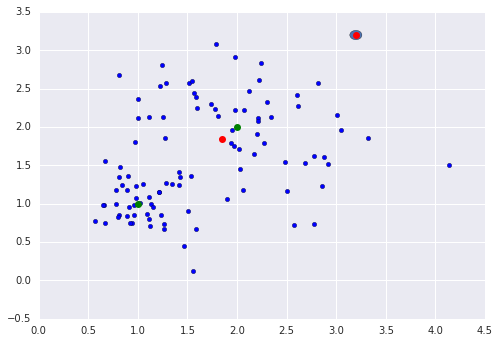

In [120]:
plt.scatter(*X.T)
plt.plot(w[0][0],w[0][1],'ro')
plt.plot(w[1][0],w[1][1],'ro')
plt.gca().add_artist(plt.Circle(w[0], sigma[0]))
plt.gca().add_artist(plt.Circle(w[1], sigma[1]))
plt.plot(w1[0],w1[1],'go')
plt.plot(w2[0],w2[1],'go')


In [132]:
from sklearn.cluster import KMeans
km = KMeans(2)
km.fit(X)
centers = km.cluster_centers_
preds = km.predict(X)

In [134]:
preds

array([0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1], dtype=int32)

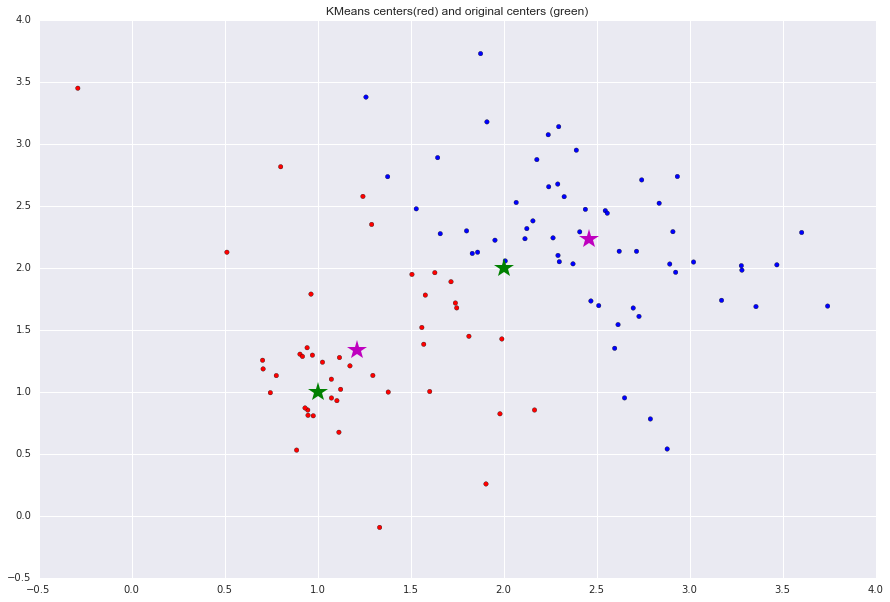

In [148]:
plt.figure(figsize = (15,10))
plt.scatter(*X.T, c = ['r' if p==1 else 'b' for p in preds])
plt.plot(centers[0][0],centers[0][1],'m*', markersize = 20)
plt.plot(centers[1][0],centers[1][1],'m*', markersize = 20)
plt.plot(w1[0],w1[1],'g*', markersize = 20)
plt.plot(w2[0],w2[1],'g*', markersize = 20)
plt.title('KMeans centers(red) and original centers (green)')